# Importing Liabrary

In [1]:
import re
import nltk
import spacy
import codecs
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from wordcloud import WordCloud
from nltk.corpus import stopwords
from bs4 import BeautifulSoup as bs
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.express as px
from sklearn.metrics import confusion_matrix

from collections import Counter, defaultdict
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot
from nltk.sentiment import SentimentIntensityAnalyzer

#Load Dataset

In [3]:
df=pd.read_excel('/content/hotel_reviews.xlsx')
reviews=df.copy()

In [4]:
df = df.drop('@', axis=1)

In [5]:
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


In [6]:
df.shape

(20491, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [8]:
df['Rating'].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [9]:
len(df.Review.unique()), df.isna().sum()

(20491,
 Review    0
 Rating    0
 dtype: int64)

# Data Visualization

In [10]:
# label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2

# label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

In [11]:
# encode label and mapping label name
df["label"] = df["Rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

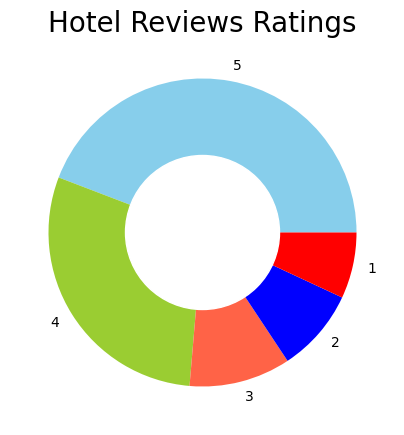

In [12]:
ratings = df["Rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(5, 5))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Hotel Reviews Ratings", fontsize=20)
plt.show()

In [13]:
x = df.Rating.value_counts().reset_index().rename(columns={'index': 'Rating', 'Rating': 'Count'})
fig = px.bar(x,
             x="Rating",
             y="Count",
             color="Rating",
             color_continuous_scale=["#EF553B", "#FFA15A", "#FECB52", "#B6E880", "#00CC96"],
             title="Reviews By Rating"
            )


fig.update_layout(coloraxis_showscale=False)
fig.update_traces(text=x["Count"], textposition="outside")

fig.show()

In [14]:
df['text_length'] = df.Review.str.len()

fig = px.histogram(df,
                   x='text_length',
                   color='Rating',
                   color_discrete_sequence=["#B6E880", "#FFA15A", "#FECB52", "#00CC96", "#EF553B"],
                   title="Review Length Distributions"
                  )

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=0,r=0,b=0)
)

fig.show()

# Exploratory Data Analysis

## Counts and Lenght:
### Start by checking how long the reviews are

- Character count
- Word count
- Mean word length
- Mean sentence length

In [15]:
reviews1=df.copy()
reviews1.head()

,Review,Rating,label,label_name,text_length
0,nice hotel expensive parking got good deal sta...,4,2,Positive,593
1,ok nothing special charge diamond member hilto...,2,0,Negative,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral,1427
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive,600
4,"great stay great stay, went seahawk game aweso...",5,2,Positive,1281


In [16]:
lenght = len(reviews1['Review'][0])
print(f'Length of a sample review: {lenght}')

Length of a sample review: 593


In [17]:
reviews1['Length'] = reviews1['Review'].str.len()
reviews1.head(10)

,Review,Rating,label,label_name,text_length,Length
0,nice hotel expensive parking got good deal sta...,4,2,Positive,593,593
1,ok nothing special charge diamond member hilto...,2,0,Negative,1689,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral,1427,1427
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive,600,600
4,"great stay great stay, went seahawk game aweso...",5,2,Positive,1281,1281
5,love monaco staff husband stayed hotel crazy w...,5,2,Positive,1002,1002
6,"cozy stay rainy city, husband spent 7 nights m...",5,2,Positive,748,748
7,"excellent staff, housekeeping quality hotel ch...",4,2,Positive,597,597
8,"hotel stayed hotel monaco cruise, rooms genero...",5,2,Positive,419,419
9,excellent stayed hotel monaco past w/e delight...,5,2,Positive,271,271


In [18]:
word_count = reviews1['Review'][0].split()
print(f'Word count in a sample review: {len(word_count)}')

Word count in a sample review: 87


## Word Count: Number of words in a review

In [19]:
def word_count(reviews1):
    review_list = reviews1.split()
    return len(review_list)

In [20]:
reviews1['Word_count'] = reviews1['Review'].apply(word_count)
reviews1.head(10)

,Review,Rating,label,label_name,text_length,Length,Word_count
0,nice hotel expensive parking got good deal sta...,4,2,Positive,593,593,87
1,ok nothing special charge diamond member hilto...,2,0,Negative,1689,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral,1427,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive,600,600,89
4,"great stay great stay, went seahawk game aweso...",5,2,Positive,1281,1281,191
5,love monaco staff husband stayed hotel crazy w...,5,2,Positive,1002,1002,134
6,"cozy stay rainy city, husband spent 7 nights m...",5,2,Positive,748,748,101
7,"excellent staff, housekeeping quality hotel ch...",4,2,Positive,597,597,85
8,"hotel stayed hotel monaco cruise, rooms genero...",5,2,Positive,419,419,59
9,excellent stayed hotel monaco past w/e delight...,5,2,Positive,271,271,35


# Mean word length: Average length of words

In [21]:
reviews1['mean_word_length'] = reviews1['Review'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
reviews1.head(10)

,Review,Rating,label,label_name,text_length,Length,Word_count,mean_word_length
0,nice hotel expensive parking got good deal sta...,4,2,Positive,593,593,87,5.804598
1,ok nothing special charge diamond member hilto...,2,0,Negative,1689,1689,250,5.752000
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral,1427,1427,217,5.571429
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive,600,600,89,5.730337
4,"great stay great stay, went seahawk game aweso...",5,2,Positive,1281,1281,191,5.701571
5,love monaco staff husband stayed hotel crazy w...,5,2,Positive,1002,1002,134,6.470149
6,"cozy stay rainy city, husband spent 7 nights m...",5,2,Positive,748,748,101,6.396040
7,"excellent staff, housekeeping quality hotel ch...",4,2,Positive,597,597,85,6.011765
8,"hotel stayed hotel monaco cruise, rooms genero...",5,2,Positive,419,419,59,6.084746
9,excellent stayed hotel monaco past w/e delight...,5,2,Positive,271,271,35,6.714286


# Mean sentence length: Average length of the sentences in the review

In [22]:
import nltk
nltk.download('punkt')

# Import the sent_tokenize function
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
sentences = sent_tokenize(reviews1['Review'][0])

# Calculate the mean length of sentences
mean_sentence_length = np.mean([len(sent) for sent in sentences])

print("Mean sentence length:", mean_sentence_length)

Mean sentence length: 591.0


In [24]:
reviews1['mean_sent_length'] = reviews1['Review'].apply(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))

reviews1.head(10)

,Review,Rating,label,label_name,text_length,Length,Word_count,mean_word_length,mean_sent_length
0,nice hotel expensive parking got good deal sta...,4,2,Positive,593,593,87,5.804598,591.0
1,ok nothing special charge diamond member hilto...,2,0,Negative,1689,1689,250,5.752000,1687.0
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral,1427,1427,217,5.571429,712.0
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive,600,600,89,5.730337,598.0
4,"great stay great stay, went seahawk game aweso...",5,2,Positive,1281,1281,191,5.701571,1279.0
5,love monaco staff husband stayed hotel crazy w...,5,2,Positive,1002,1002,134,6.470149,1000.0
6,"cozy stay rainy city, husband spent 7 nights m...",5,2,Positive,748,748,101,6.396040,746.0
7,"excellent staff, housekeeping quality hotel ch...",4,2,Positive,597,597,85,6.011765,595.0
8,"hotel stayed hotel monaco cruise, rooms genero...",5,2,Positive,419,419,59,6.084746,417.0
9,excellent stayed hotel monaco past w/e delight...,5,2,Positive,271,271,35,6.714286,269.0


# Wordcloud

In [25]:
def show_wordcloud(reviews, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(reviews))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

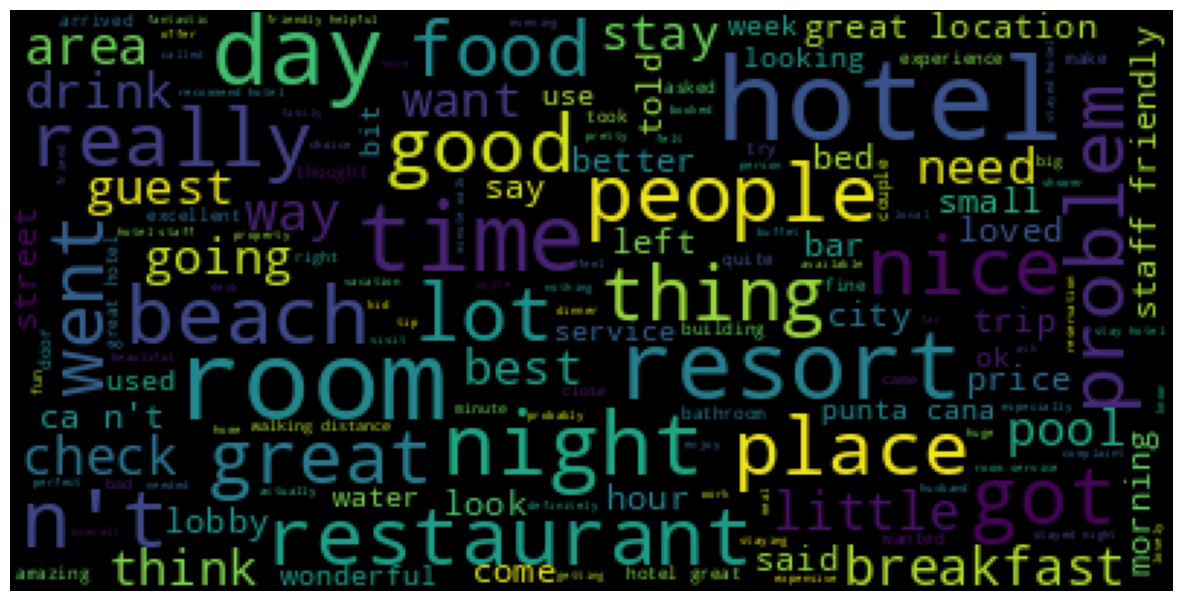

In [26]:
show_wordcloud(reviews["Review"].values)

#BasicText Preprocessing for Sentiment Analysis
##Spelling Correction

In [27]:
reviews['Review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms not 4* experience hotel monarch sea...
3    unique, great stay, wonderful time hotel monar...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

In [28]:
Reviews1= reviews[['Review']]
Reviews1

,Review
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...
3,"unique, great stay, wonderful time hotel monac..."
4,"great stay great stay, went seahawk game aweso..."
...,...
20486,"best kept secret 3rd time staying charm, not 5..."
20487,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ..."
20489,hotel theft ruined vacation hotel opened sept ...


# Resetting index

In [29]:
!pip install nltk

In [30]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
Reviews1.reset_index(drop=True, inplace=True)

In [32]:
stop_words = stopwords.words('english')
Reviews1['Review'] = Reviews1['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop_words))

# Lemmatizer

In [33]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(Reviews1))):
    cleaned = re.sub('[^a-zA-Z]', " ", Reviews1["Review"][i])
    cleaned = cleaned.lower()
    cleaned = cleaned.split()
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/20491 [00:00<?, ?it/s]

In [34]:
#Saving cleaned data to compare with original data, to ckeck amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": Reviews1.Review})
dataframe.head()


,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."


#Text Pre-processing Techniques
##A. Removing '@names'

In [35]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)

    return text

In [36]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
dataframe['Clean_Reviews'] = np.vectorize(remove_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...


#B. Removing links (http | https)

In [37]:
cleaned_reviews = []

for index, row in dataframe.iterrows():
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...


#C. Removing Review with empty text

In [38]:
dataframe = dataframe[dataframe['Clean_Reviews']!='']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...


# D. Dropping duplicate rows

In [39]:
dataframe.drop_duplicates(subset=['Clean_Reviews'], keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...


#E. Function to remove emoji

In [40]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [41]:
dataframe['Clean_Reviews']=dataframe['Clean_Reviews'].apply(lambda x: remove_emoji(x))
dataframe.head(10)


,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...


# F. Removing Stop words

In [42]:
from nltk.corpus import stopwords

# Download the NLTK stopwords list if you haven't already
nltk.download('stopwords')

# Load NLTK stopwords
stopwords_set = set(stopwords.words('english'))

# Assuming 'dataframe' is a pandas DataFrame containing your data
cleaned_reviews = []

for index, row in dataframe.iterrows():
    # Remove URLs and stopwords
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word and word.lower() not in stopwords_set]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Clean_Reviews,Uncleaned_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...


# Tokenize 'Clean_Reviews'

In [43]:
nltk.download('punkt')
TextBlob(dataframe['Clean_Reviews'][1]).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordList(['ok', 'nothing', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', 'th', 'anniversary', 'seattle', 'start', 'booked', 'suite', 'paid', 'extra', 'website', 'description', 'suite', 'bedroom', 'bathroom', 'standard', 'hotel', 'room', 'took', 'printed', 'reservation', 'desk', 'showed', 'said', 'thing', 'like', 'tv', 'couch', 'ect', 'desk', 'clerk', 'told', 'oh', 'mixed', 'suite', 'description', 'kimpton', 'website', 'sorry', 'free', 'breakfast', 'got', 'kidding', 'embassy', 'suit', 'sitting', 'room', 'bathroom', 'bedroom', 'unlike', 'kimpton', 'call', 'suite', 'day', 'stay', 'offer', 'correct', 'false', 'advertising', 'send', 'kimpton', 'preferred', 'guest', 'website', 'email', 'asking', 'failure', 'provide', 'suite', 'advertised', 'website', 'reservation', 'description', 'furnished', 'hard', 'copy', 'reservation', 'printout', 'website', 'desk', 'manager', 'duty', 'reply', 'solution', 'send', 'email', 'trip', 'guest', 'survey', 'follow', 'email', 'ma

In [44]:
tokenized_review = dataframe['Clean_Reviews'].apply(lambda x: x.split())
tokenized_review.head(10)

0    [nice, hotel, expensive, parking, got, good, d...
1    [ok, nothing, special, charge, diamond, member...
2    [nice, room, experience, hotel, monaco, seattl...
3    [unique, great, stay, wonderful, time, hotel, ...
4    [great, stay, great, stay, went, seahawk, game...
5    [love, monaco, staff, husband, stayed, hotel, ...
6    [cozy, stay, rainy, city, husband, spent, nigh...
7    [excellent, staff, housekeeping, quality, hote...
8    [hotel, stayed, hotel, monaco, cruise, room, g...
9    [excellent, stayed, hotel, monaco, past, w, e,...
Name: Clean_Reviews, dtype: object

In [45]:
dataframe['Tokenized_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member..."
2,nice room experience hotel monaco seattle good...,nice rooms 4* experience hotel monaco seattle ...,"[nice, room, experience, hotel, monaco, seattl..."
3,unique great stay wonderful time hotel monaco ...,"unique, great stay, wonderful time hotel monac...","[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,"great stay great stay, went seahawk game aweso...","[great, stay, great, stay, went, seahawk, game..."
5,love monaco staff husband stayed hotel crazy w...,love monaco staff husband stayed hotel crazy w...,"[love, monaco, staff, husband, stayed, hotel, ..."
6,cozy stay rainy city husband spent night monac...,"cozy stay rainy city, husband spent 7 nights m...","[cozy, stay, rainy, city, husband, spent, nigh..."
7,excellent staff housekeeping quality hotel cho...,"excellent staff, housekeeping quality hotel ch...","[excellent, staff, housekeeping, quality, hote..."
8,hotel stayed hotel monaco cruise room generous...,"hotel stayed hotel monaco cruise, rooms genero...","[hotel, stayed, hotel, monaco, cruise, room, g..."
9,excellent stayed hotel monaco past w e delight...,excellent stayed hotel monaco past w/e delight...,"[excellent, stayed, hotel, monaco, past, w, e,..."


# Converting words to Stemmer

In [46]:
stemmer = SnowballStemmer("english")

In [47]:
st = pd.DataFrame()
st['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
st

,stemmed
0,nice hotel expens park got good deal stay hote...
1,ok noth special charg diamond member hilton de...
2,nice room experi hotel monaco seattl good hote...
3,uniqu great stay wonder time hotel monaco loca...
4,great stay great stay went seahawk game awesom...
...,...
20486,best kept secret rd time stay charm star ca n ...
20487,great locat price view hotel great quick place...
20488,ok look nice modern outsid desk staff n partic...
20489,hotel theft ruin vacat hotel open sept guest w...


# Converting words to Lemma

In [48]:
word_lemmatizer = WordNetLemmatizer()
lem = pd.DataFrame()
lem['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
lem

,stemmed
0,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...
2,nice room experience hotel monaco seattle good...
3,unique great stay wonderful time hotel monaco ...
4,great stay great stay went seahawk game awesom...
...,...
20486,best kept secret rd time staying charm star ca...
20487,great location price view hotel great quick pl...
20488,ok look nice modern outside desk staff n parti...
20489,hotel theft ruined vacation hotel opened sept ...



# 8. Basic Feature Extaction
## A. Applying bag of Words without N grams

In [49]:
!pip install -U scikit-learn
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)

In [51]:
print(cv.get_feature_names_out()[109:200])

['absolubt' 'absoluetly' 'absolultely' 'absolulty' 'absolut' 'absolutaley'
 'absolutaly' 'absolute' 'absoluteley' 'absolutely' 'absolutelyloved'
 'absolutey' 'absolutley' 'absolutly' 'absorb' 'absorbant' 'absorbed'
 'absorber' 'absorbing' 'absorption' 'absortion' 'absouloutly' 'absoulte'
 'absoultely' 'absoultley' 'absoultly' 'absoulty' 'absoulutely'
 'absoutely' 'absoutly' 'abstract' 'absulutely' 'absurd' 'absurdly' 'abt'
 'abuela' 'abuelita' 'abundance' 'abundant' 'abundantly' 'abundence'
 'abundent' 'abundently' 'aburpt' 'abuse' 'abused' 'abusive' 'abut'
 'abuts' 'abve' 'abysmal' 'abysmally' 'abyssmal' 'ac' 'acacia' 'acadamia'
 'acadamies' 'academia' 'academic' 'academician' 'academie' 'academy'
 'acampa' 'acampapr' 'acapolco' 'acapulco' 'acar' 'acarte' 'acca'
 'accadamia' 'accademia' 'accademie' 'accademina' 'accademy' 'accces'
 'acccomadate' 'acccurate' 'acceded' 'accedemia' 'acceess' 'accelerate'
 'accelerating' 'accelerator' 'accellerate' 'accent' 'accented'
 'accentuate' 'accen

In [52]:
print(cv.get_feature_names_out()[:100])

['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaaaaa' 'aaaaaaaaaaaaaaa' 'aaaare' 'aaah'
 'aaahhh' 'aadvantage' 'aah' 'aahh' 'aalders' 'aand' 'aany' 'aaron' 'aarp'
 'aarrgh' 'aavacations' 'ab' 'abac' 'aback' 'abaited' 'abalone' 'abandon'
 'abandoned' 'abandoning' 'abatement' 'abba' 'abbaye' 'abbelouie'
 'abberation' 'abbey' 'abbot' 'abbott' 'abbreviated' 'abby' 'abc' 'abd'
 'abderahim' 'abdication' 'abdomen' 'abdominal' 'abdulaziz' 'abe'
 'abeautiful' 'abel' 'aber' 'abercrombie' 'aberdeen' 'abessess' 'abetter'
 'abian' 'abide' 'abiding' 'abigail' 'ability' 'abis' 'abit' 'ablast'
 'able' 'abled' 'ableto' 'abnormal' 'aboard' 'abode' 'aboit' 'abolished'
 'abolutely' 'abominable' 'abondon' 'abono' 'aboot' 'aboout' 'aboput'
 'aboriginal' 'aborted' 'aboslutely' 'abosolutely' 'abosolutey'
 'abosultely' 'abot' 'abottle' 'abou' 'abound' 'abounded' 'abounds'
 'abouot' 'abour' 'abouta' 'aboutthe' 'abraham' 'abrahan' 'abrasion'
 'abrasive' 'abreast' 'abroad' 'abrupt' 'abruptly' 'abruptness']


In [53]:
print(tweetscv.toarray()[100:200])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Most Common Word

In [54]:
import nltk
# nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
texts = dataframe['Clean_Reviews']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

# Most Common ngrams

In [56]:
color = ['gold', 'mediumturquoise', 'lightgreen']
colors=color.copy()
fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = reviews1[reviews1["label"] == i]['Review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []

    for word, count in most[:30]:
        if word not in stopWords_nltk:
            x.append(word)
            y.append(count)

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common ngrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ),)


fig.show()

In [57]:
def _get_top_ngram(corpus, n=None):
    #getting top ngrams
    vec = CountVectorizer(ngram_range=(n, n),
                          max_df=0.9,
                          ).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:15]

#Bigram

In [58]:

fig = make_subplots(rows=1, cols=3)

title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = reviews1[reviews1["label"] == i]['Review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    top_n_bigrams = _get_top_ngram(texts, 2)[:15]
    x, y = map(list, zip(*top_n_bigrams))


    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1)


fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common bigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))
fig.show()


# Trigram

In [59]:

fig = make_subplots(rows=1, cols=3)
title_ = ["negative", "neutral", "positive"]

for i in range(3):
    texts = reviews1[reviews1["label"] == i]['Review']

    new = texts.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    top_n_bigrams = _get_top_ngram(texts, 3)[:15]
    x, y = map(list, zip(*top_n_bigrams))

    fig.add_trace(go.Bar(
                x=y,
                y=x,
                orientation='h', type="bar",
        name=title_[i], marker=dict(color=colors[i])), 1, i+1),

fig.update_layout(
    autosize=False,
    width=2000,
    height=600,title=dict(
        text='<b>Most Common trigrams per Classes</b>',
        x=0.5,
        y=0.95,
        font=dict(
        family="Courier New, monospace",
        size=24,
        color="RebeccaPurple"
        )
    ))

fig.show()


In [60]:
import string

In [61]:
reviews['Length'] = reviews['Review'].apply(len)

In [62]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [63]:
reviews1['Review'] = reviews1['Review'].apply(cleaning)

In [64]:
length = reviews['Length'].sum()

In [65]:
reviews1['text_length'] = reviews1['Review'].apply(len)
new_length = reviews1['text_length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14861007
Total text length after cleaning: 13548729


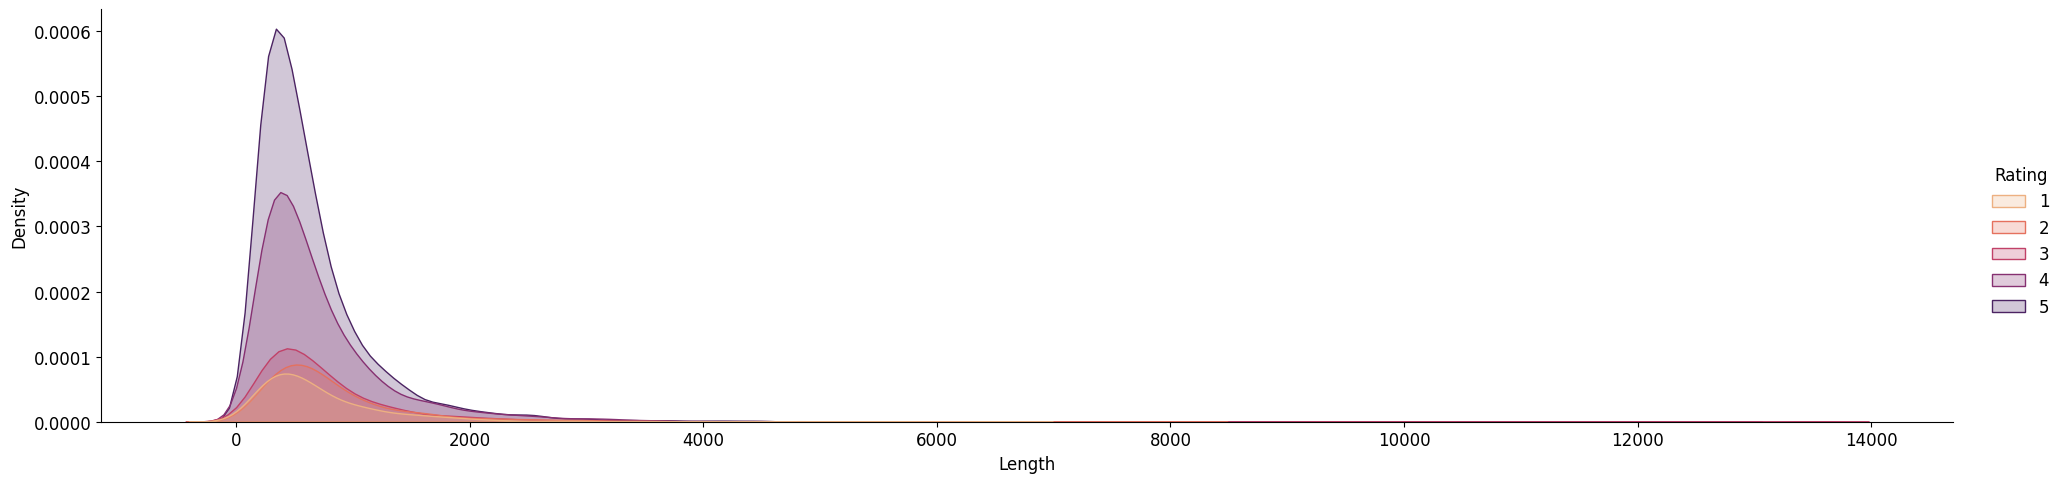

In [66]:
sns.displot(data=reviews, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

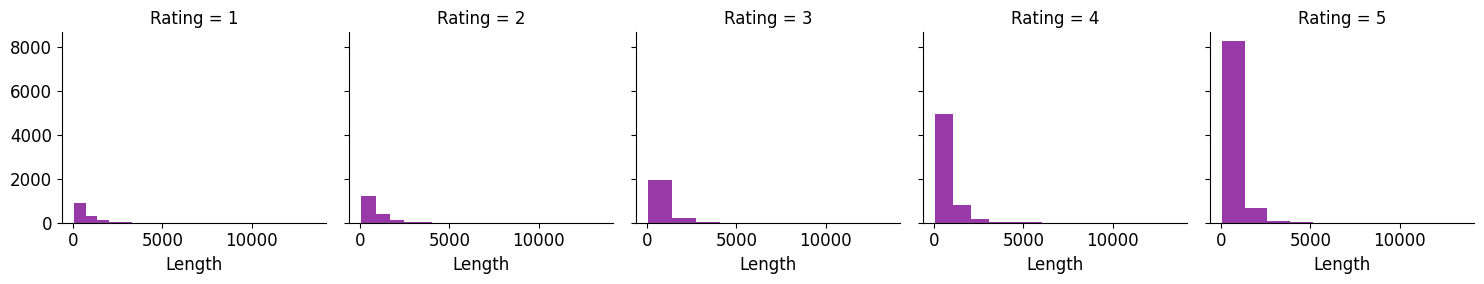

In [67]:
 g = sns.FacetGrid(data=reviews, col='Rating')
 g.map(plt.hist, 'Length', color='#973aa8')

# After cleaning, let's see the most common used word

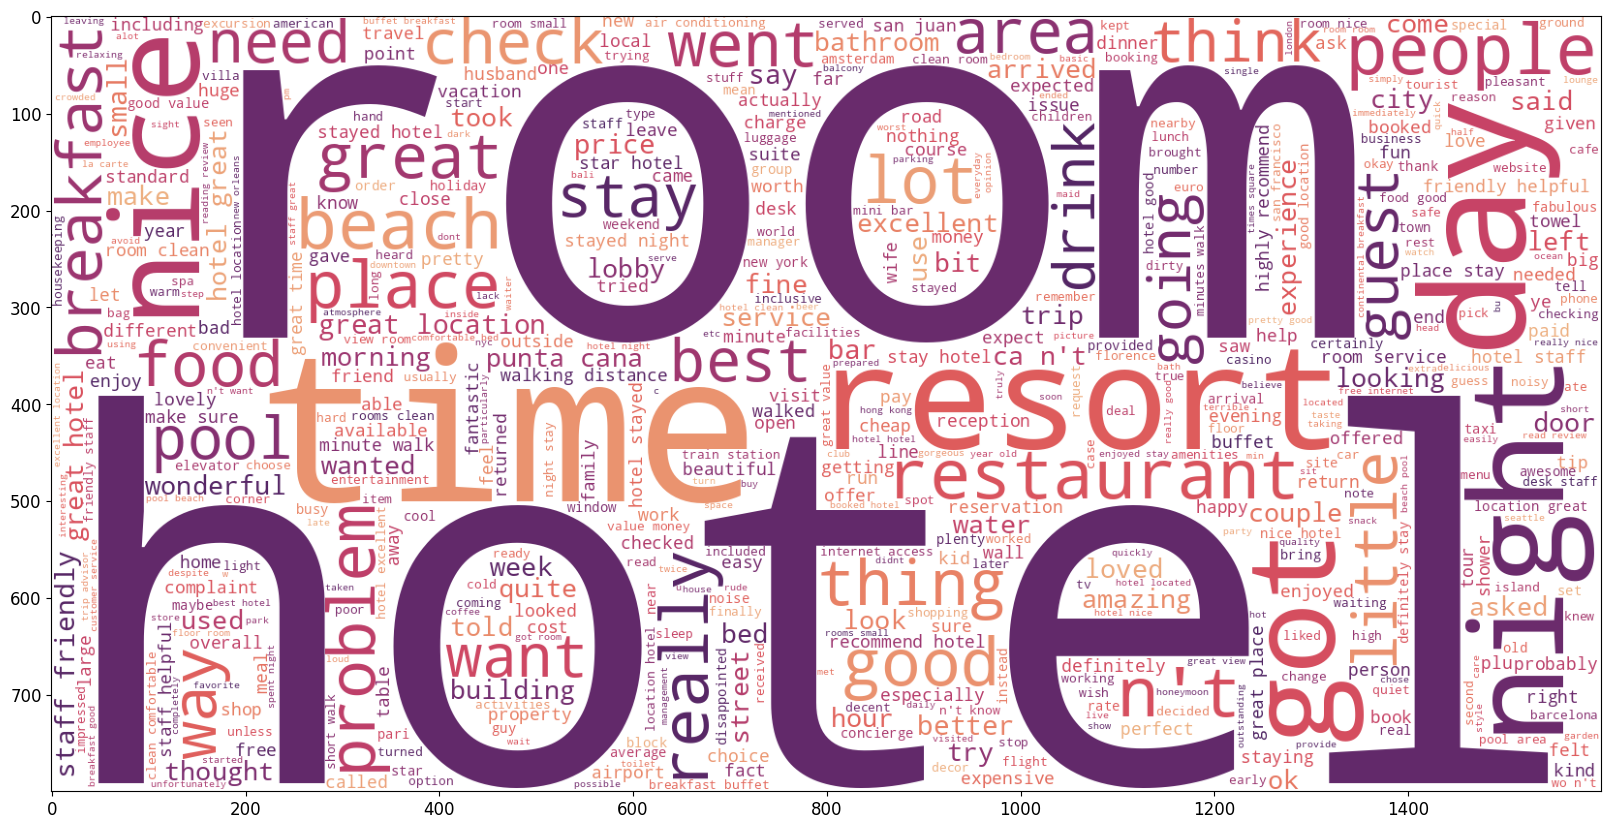

In [68]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(reviews['Review']))

plt.imshow(wc)

# TF-IDF Vectorizer

In [69]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/20491 [00:00<?, ?it/s]

In [70]:
corpus[4]

'great stay great stay went seahawk game awesom downfal view build n complain room huge staff help book hotel websit seahawk packag charg park got voucher taxi problem taxi driver n want accept voucher bare spoke english funni thing speak arab call start make comment girlfriend cell phone buddi took second realiz said fact speak languag face priceless told said larg citi told head doorman issu call cab compani prompli answer n apolog offer pay taxi buck mile stadium game plan taxi return go humpin great walk n mind right christma wonder light homeless stow away build entranc leav polic presenc greatest area stadium activ block pike street waterfront great coffe shop way hotel mantain foyer awesom wine tast avail even best dog take st bernard time famili safe hotel locat servic desk room bathroom huge jet tub huge funni hous keep walk girlfriend get dress n hear knock turn servic scream girlfriend scream hit floor laugh start talk spanish work place recommend price check onlin deal good

# Applying TF-IDF Vectorizer

In [71]:
tfidf_v = TfidfVectorizer(max_features=10000,ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()

In [72]:
X.shape

(20491, 10000)

In [73]:
tfidf_v.get_feature_names_out()[:200]

array(['aaa', 'abc', 'abil', 'abl', 'abl check', 'abl enjoy', 'abl make',
       'abl room', 'abl sleep', 'abl stay', 'abl use', 'abl walk',
       'abroad', 'absolut', 'absolut amaz', 'absolut beauti',
       'absolut best', 'absolut fabul', 'absolut fantast',
       'absolut gorgeou', 'absolut love', 'absolut noth',
       'absolut perfect', 'absolut stay', 'absolut wonder', 'absolutli',
       'abund', 'ac', 'ac work', 'accademia', 'accept', 'access',
       'access avail', 'access free', 'access hotel', 'access internet',
       'access lobbi', 'access room', 'accid', 'accomad', 'accomid',
       'accommod', 'accomod', 'accompani', 'accord', 'accordingli',
       'account', 'accross', 'accur', 'accustom', 'acknowledg', 'act',
       'act like', 'action', 'activ', 'activ day', 'activ go',
       'activ staff', 'activit', 'actual', 'actual hotel', 'actual quit',
       'actual room', 'actual stay', 'ad', 'ad bonu', 'adagio', 'adam',
       'adapt', 'add', 'addit', 'addit charg', 'add

In [74]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 10000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

# Named Entity Recognition (NER)

In [75]:
reviews_df = [review.strip() for review in dataframe.Clean_Reviews]
reviews_df = [comment for comment in reviews_df if comment]
# Joining the list into one string/text
reviews_text = ' '.join(reviews_df)
reviews_text[0:2000]


'nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said thing like tv couch ect desk clerk told oh mixed suite description kimpton website sorry free breakfast got kidding embassy suit sitting room bathroom bedroom unlike kimpton call suite day stay offer correct false advertising send

#  Parts Of Speech (POS) Tagging

In [76]:
nlp = spacy.load('en_core_web_sm')

one_block = reviews_text[0:3000]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)


In [77]:
for token in doc_block[100:150]:
    print(token,token.pos_)

description NOUN
suite NOUN
bedroom NOUN
bathroom NOUN
standard ADJ
hotel NOUN
room NOUN
took VERB
printed VERB
reservation NOUN
desk NOUN
showed VERB
said VERB
thing NOUN
like ADP
tv NOUN
couch NOUN
ect NOUN
desk NOUN
clerk NOUN
told VERB
oh INTJ
mixed ADJ
suite NOUN
description NOUN
kimpton PROPN
website PROPN
sorry PROPN
free ADJ
breakfast NOUN
got VERB
kidding VERB
embassy NOUN
suit NOUN
sitting VERB
room NOUN
bathroom NOUN
bedroom NOUN
unlike ADP
kimpton PROPN
call PROPN
suite PROPN
day NOUN
stay VERB
offer NOUN
correct VERB
false ADJ
advertising NOUN
send VERB
kimpton PROPN


#Filtering the nouns and verbs only

In [78]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [79]:
# nlp.max_length =  13669074
# one_block=reviews_text
# doc_block=nlp(one_block)
# nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
# print(nouns_verbs[100:2000])

In [80]:

# cv = CountVectorizer()
# X = cv.fit_transform(nouns_verbs)
# sum_words = X.sum(axis=0)

# words_freq = [(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
# words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# wd_df = pd.DataFrame(words_freq)
# wd_df.columns = ['word','count']
# wd_df[0:10]

# Vadar Sentiment Analysis

In [150]:
! pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [151]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [152]:
SIAz = SentimentIntensityAnalyzer()

In [154]:
sentence = "Ram is really good "
sentiment_dict = SIAz.polarity_scores(sentence)
print(sentiment_dict)

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}


In [156]:
sentence = "Rahul is really bad"
sentiment_dict = SIAz.polarity_scores(sentence)
print(sentiment_dict)

{'neg': 0.558, 'neu': 0.442, 'pos': 0.0, 'compound': -0.5849}


In [160]:
sentiment_dict1 = SIAz.polarity_scores(dataframe['Clean_Reviews'][:500])
print(sentiment_dict1)

{'neg': 0.068, 'neu': 0.65, 'pos': 0.281, 'compound': 1.0}


In [81]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [82]:
# Define a function to classify the sentiment of a review
sia = SentimentIntensityAnalyzer()

def get_sentiment(review):
    scores = sia.polarity_scores(review)
    sentiment_score = scores['compound']
    if sentiment_score > 0.1:
        return 'positive'
    elif sentiment_score < -0.1:
        return 'negative'
    else:
        return 'neutral'

# Apply function on dataset copy
reviews2 = reviews1.copy()
reviews2['Predicted_Sentiment'] = reviews2['Review'].apply(get_sentiment)

# Print the number of positive, negative, and neutral reviews
print("Number of positive reviews:", len(reviews2[reviews2['Predicted_Sentiment'] == 'positive']))
print("Number of negative reviews:", len(reviews2[reviews2['Predicted_Sentiment'] == 'negative']))
print("Number of neutral reviews:", len(reviews2[reviews2['Predicted_Sentiment'] == 'neutral']))

Number of positive reviews: 19429
Number of negative reviews: 922
Number of neutral reviews: 140


#Map the rating column to create new column true sentiment

In [83]:
reviews2['True_Sentiment'] = reviews2['Rating'].map({1: 'negative',
                                           2: 'negative',
                                           3: 'neutral',
                                           4: 'positive',
                                           5: 'positive'})

#Calculate confusion matrix

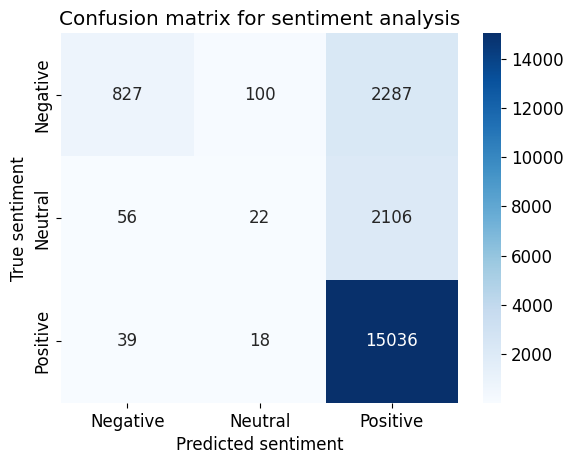

In [84]:
cm = confusion_matrix(reviews2['True_Sentiment'], reviews2['Predicted_Sentiment'])

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.title('Confusion matrix for sentiment analysis')
plt.show()

In [85]:
from sklearn.metrics import classification_report
print("\nClassification report:\n", classification_report(reviews2['True_Sentiment'],
                                                          reviews2['Predicted_Sentiment']))


Classification report:
               precision    recall  f1-score   support

    negative       0.90      0.26      0.40      3214
     neutral       0.16      0.01      0.02      2184
    positive       0.77      1.00      0.87     15093

    accuracy                           0.78     20491
   macro avg       0.61      0.42      0.43     20491
weighted avg       0.73      0.78      0.71     20491



# Prediction Rating

In [89]:
# Define function for new column sentiment
positive = [4, 5]
neutral = [3]
negative = [1, 2]

def map_sentiment(rating):
    if rating in positive:
        return 2
    elif rating in neutral:
        return 1
    else:
        return 0

reviews2['Sentiment']= reviews2['Rating'].apply(map_sentiment)

# Prepare data for modeling

In [96]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [100]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(reviews2['Review'])
y = reviews2['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=24)

# Logistic Regression

In [101]:
# Build model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_lr = accuracy_score(y_test, predicted_lr)
print('Accuracy:', accuracy_lr)
print('Classification Report:')
print(classification_report(y_test, predicted_lr))

Accuracy: 0.852820612922116
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       810
           1       0.56      0.17      0.26       565
           2       0.87      0.98      0.93      3748

    accuracy                           0.85      5123
   macro avg       0.74      0.62      0.65      5123
weighted avg       0.83      0.85      0.83      5123



## Build confusion matrix

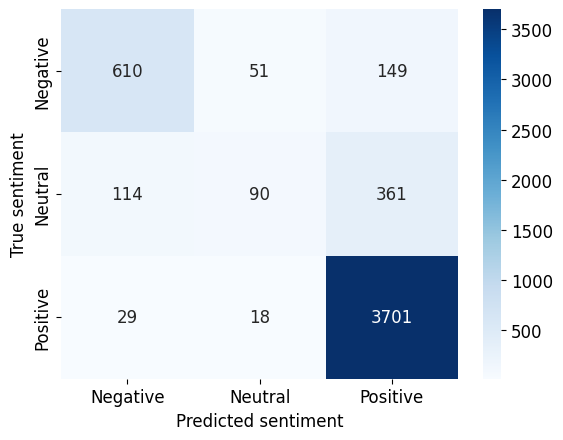

In [98]:
cm_lr = confusion_matrix(y_test, predicted_lr)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

In [102]:
print("\nClassification report:\n", classification_report(reviews2['True_Sentiment'],
                                                          reviews2['Predicted_Sentiment']))


Classification report:
               precision    recall  f1-score   support

    negative       0.90      0.26      0.40      3214
     neutral       0.16      0.01      0.02      2184
    positive       0.77      1.00      0.87     15093

    accuracy                           0.78     20491
   macro avg       0.61      0.42      0.43     20491
weighted avg       0.73      0.78      0.71     20491



# Linear Support Vector Classification

In [103]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)

predicted_svc = svc.predict(X_test)

# Calculate accuracy and print classification report
accuracy_svc = accuracy_score(y_test, predicted_svc)
print('Accuracy:', accuracy_svc)
print('Classification Report:')
print(classification_report(y_test, predicted_svc))

Accuracy: 0.8481358578957642
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       810
           1       0.46      0.22      0.29       565
           2       0.89      0.97      0.93      3748

    accuracy                           0.85      5123
   macro avg       0.71      0.64      0.66      5123
weighted avg       0.82      0.85      0.83      5123



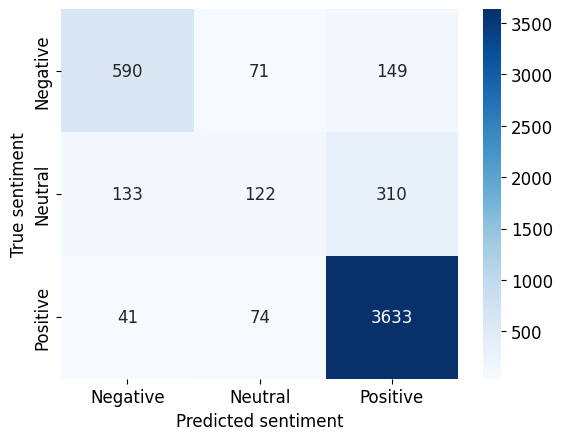

In [104]:
# Build confusion matrix
cm_svc = confusion_matrix(y_test, predicted_svc)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

#Random Forest Classifier

In [105]:
# Build the model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predicted_rf = rf.predict(X_test)

# Calculate accuracy and print classification report
accuracy_rf = accuracy_score(y_test, predicted_rf)
print('Accuracy:', accuracy_rf)
print('Classification Report:')
print(classification_report(y_test, predicted_rf))

Accuracy: 0.7993363263712668
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58       810
           1       1.00      0.01      0.01       565
           2       0.79      1.00      0.88      3748

    accuracy                           0.80      5123
   macro avg       0.90      0.48      0.49      5123
weighted avg       0.83      0.80      0.74      5123



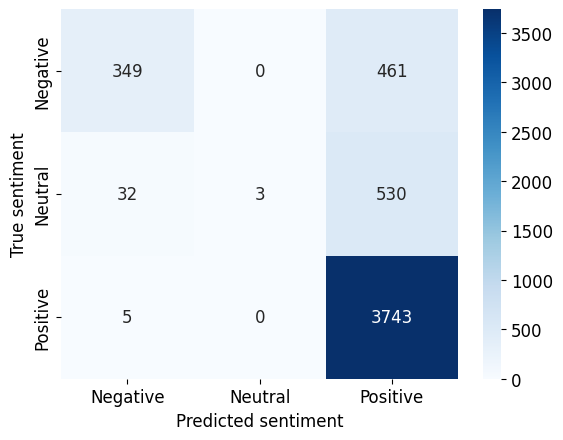

In [106]:
# Build confusion matrix
cm_rf = confusion_matrix(y_test, predicted_rf)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# Naive Bayes Multinominal

In [107]:
# Build the model
nb = MultinomialNB()
nb.fit(X_train, y_train)

predicted_nb = nb.predict(X_test)

# Calculate accuracy and print classification report
accuracy_nb = accuracy_score(y_test, predicted_nb)
print('Accuracy:', accuracy_nb)
print('Classification Report:')
print(classification_report(y_test, predicted_nb))

Accuracy: 0.8213937146203396
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       810
           1       1.00      0.00      0.00       565
           2       0.82      0.99      0.90      3748

    accuracy                           0.82      5123
   macro avg       0.88      0.53      0.53      5123
weighted avg       0.84      0.82      0.77      5123



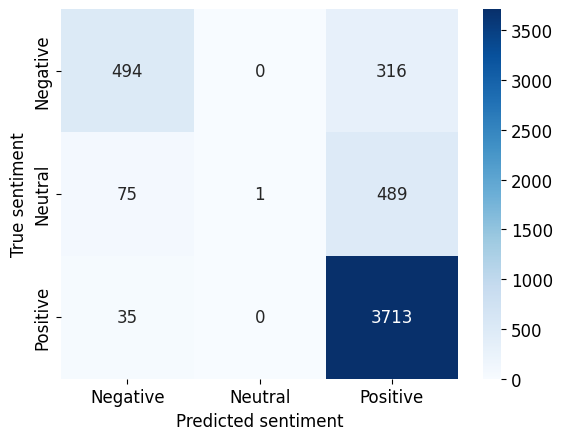

In [108]:
# Build confusion matrix
cm_nb = confusion_matrix(y_test, predicted_nb)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# XGBoost

In [109]:
# Build the model
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)

predicted_xgb = xgb.predict(X_test)

# Calculate accuracy and print classification report
accuracy_xgb = accuracy_score(y_test, predicted_xgb)
print('Accuracy:', accuracy_xgb)
print('Classification Report:')
print(classification_report(y_test, predicted_xgb))

Accuracy: 0.8420847159867265
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       810
           1       0.52      0.19      0.27       565
           2       0.87      0.98      0.92      3748

    accuracy                           0.84      5123
   macro avg       0.73      0.61      0.64      5123
weighted avg       0.82      0.84      0.82      5123



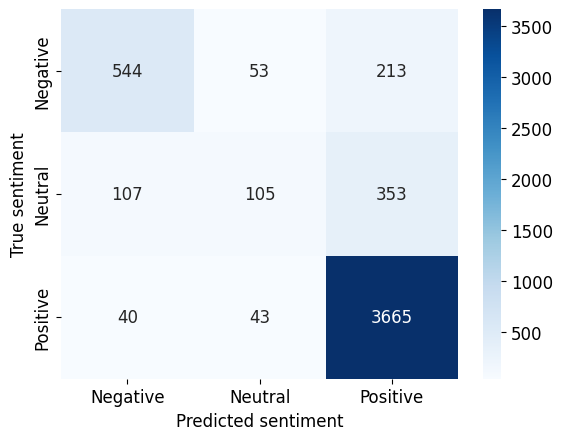

In [110]:
# Build confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_xgb)

# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

# Compare Models Performance

In [111]:
Models = ['Random Forest', 'Naive Bayes Multinominal', 'XGBoost', 'Logistic Regression', 'SVC']
Scores = [accuracy_rf, accuracy_nb, accuracy_xgb, accuracy_lr, accuracy_svc]
performance = pd.DataFrame(list(zip(Models, Scores)),
                          columns = ['Models', 'Accuracy_score'])\
                            .sort_values('Accuracy_score', ascending=False)
performance

,Models,Accuracy_score
3,Logistic Regression,0.852821
4,SVC,0.848136
2,XGBoost,0.842085
1,Naive Bayes Multinominal,0.821394
0,Random Forest,0.799336
